In [349]:
import numpy as np
import gym
import math
import time
import mdptoolbox.example as ex
from mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
import time, pickle, os
import seaborn as sns
import matplotlib.pyplot as plt
import itertools



In [179]:
def prettify_output(algo, value_array, policy_array, num_iters, total_time):
    title = {
        0: 'Value Iteration',
        1: 'Policy Iteration',
        2: 'Q-Learning'
    }[algo]
    print("{} Value Array:\n{}".format(title, value_array))
    print("{} Output Policy:\n{}".format(title, policy_array))
    print("{} - Time per iteration:\n{}".format(title, total_time/num_iters))
    print("{} - Total Iterations:\n{}".format(title, num_iters))
    print()
    
def compare_policies(p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    if np.array_equal(p1, p2):
        print("The policies are equal")
    else:
        print("There were {} differences in the policies".format(len(p1)-sum(p1 == p2)))
    print()
    
def compare_values(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    print("The difference between the value arrays is {}".format(np.mean(abs(sum(v1-v2)))))
    print()

In [68]:
forest = ex.forest(S=400, r1=10000, p=0.0000000001)
P, R = forest

vi = ValueIteration(P, R, .99999, max_iter=1000000)
vi.setVerbose()
vi.run()

print(vi.policy)
print(vi.iter)
print(vi.time)

pi = PolicyIteration(P, R, .3)
pi.setVerbose()
pi.run()
print(pi.V)
print(pi.policy)
print(pi.iter)
print(pi.time)

  Iteration		V-variation
    1		  10000.0
    2		  9999.899999000008
    3		  9999.79999900004
    4		  9999.700000000079
    5		  9999.600002000123
    6		  9999.500005000154
    7		  9999.40000900017
    8		  9999.300014000159
    9		  9999.200020000106
    10		  9999.100026999993
    11		  9999.000034999817
    12		  9998.900043999582
    13		  9998.80005399926
    14		  9998.700064998851
    15		  9998.600076998342
    16		  9998.50008999773
    17		  9998.400103997003
    18		  9998.300118996136
    19		  9998.200134995119
    20		  9998.100151993962
    21		  9998.00016999264
    22		  9997.900188991163
    23		  9997.800208989507
    24		  9997.700229987653
    25		  9997.60025198559
    26		  9997.50027498333
    27		  9997.400298980847
    28		  9997.300323978136
    29		  9997.200349975186
    30		  9997.100376971981
    31		  9997.000404968509
    32		  9996.900433964809
    33		  9996.800463960828
    34		  9996.700494956518
    35		  9996.600526951941
    36		  9996.500559

    8		  0
Iterating stopped, unchanging policy found.
(0.32967032964497034, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098893491, 1.098901098

In [45]:
forest = ex.forest()
P, R = forest

pi = QLearning(P, R, .9)
pi.policy == vi.policy

AttributeError: 'QLearning' object has no attribute 'policy'

In [116]:
def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

In [369]:
def value_iteration(env, max_iterations=100000, lmbda=0.9):
    total_iter = 0
    stateValue = [0 for i in range(env.nS)]
    newStateValue = stateValue.copy()
    for i in range(max_iterations):
        for state in range(env.nS):
            action_values = []      
            for action in range(env.nA):
                state_value = 0
                for i in range(len(env.P[state][action])):
                    prob, next_state, reward, done = env.P[state][action][i]
                    state_action_value = prob * (reward + lmbda*stateValue[next_state])
                    state_value += state_action_value
                action_values.append(state_value)      #the value of each action
                best_action = np.argmax(np.asarray(action_values))   # choose the action which gives the maximum value
                newStateValue[state] = action_values[best_action]  #update the value of the state
        if i > 1000: 
            if sum(stateValue) - sum(newStateValue) < 1e-04:   # if there is negligible difference break the loop
                break
                print(i)
        elif stateValue == newStateValue:
            break
        else:
            stateValue = newStateValue.copy()
        total_iter +=1
    
    return stateValue, total_iter

def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy

def get_qpolicy(q):
    policy = [0 for i in range(len(q))]
    for i in range(len(q)):
        policy[i] = np.argmax(q[i])
    return policy

In [305]:
STEP_REWARD = 0.0
LOSE_REWARD = 0.0
WIN_REWARD = 1.0

def avg_reward(env, s, a):
    avg_reward = 0
    for prob, next_s, reward, done in env.P[s][a]:
        if not done:
            avg_reward += prob * STEP_REWARD
        elif reward == 0.0:
#             avg_reward += prob * (-5)
            avg_reward += prob * LOSE_REWARD
        else:
#             avg_reward += prob * 10
            avg_reward += prob * WIN_REWARD
    return avg_reward
            
def random_policy(env):
    return np.random.randint(0, 4, size=env.nS)

def one_step_lookahead(env, s, value_function, gamma):
    action_values = np.zeros(env.nA)
    for a in range(env.nA):
        value = avg_reward(env, s, a)
        for p, next_s, _, _ in env.P[s][a]:
            value += gamma * p * value_function[next_s]
        action_values[a] = value
    return action_values
    
def evaluate_policy(env, policy, max_backups=1000, tol=1e-6, gamma=.9):
    old_value = np.zeros(env.nS)
    for i in range(max_backups):
        new_value = np.zeros(env.nS)
        for s in range(env.nS):
            action_values = one_step_lookahead(env, s, old_value, gamma)
            new_value[s] = action_values[policy[s]]
        if np.max(np.abs(new_value-old_value)) < tol:
            break
        old_value = new_value
    return new_value

def greedy_policy(env, value_function, gamma):
    policy = np.zeros(env.nS, dtype=np.int32)
    for s in range(env.nS):
        action_values = one_step_lookahead(env, s, value_function, gamma)
        policy[s] = np.argmax(action_values)
    return policy

def policy_iteration(env, max_steps=100, gamma=.9):
    total_iters = 0
    old_policy = random_policy(env)
    for i in range(max_steps):
        value_function = evaluate_policy(env, old_policy)
        new_policy = greedy_policy(env, value_function, gamma)
        
        if np.array_equal(new_policy, old_policy):
            break 
        old_policy = new_policy
        total_iters += 1
    return old_policy, value_function, total_iters

In [366]:
def gym_qlearning(env, total_episodes=100, max_steps=10000, lr_rate=.81, 
                  gamma=.96, epsilon =.9, decay_eps=False, decay_lr=False):

    curr_lr = lr_rate
    curr_eps = epsilon
    Q = np.zeros((env.observation_space.n, env.action_space.n))

    def choose_action(state):
        action=0
        if np.random.uniform(0, 1) < curr_eps:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state, :])
        return action

    def learn(state, state2, reward, action):
        predict = Q[state, action]
        target = reward + gamma * np.max(Q[state2, :])
        Q[state, action] = Q[state, action] + curr_lr * (target - predict)
        
    def get_random_state(all_pairs, seen_pairs):
        frontier = all_pairs - seen_pairs
        index = np.random.randint(len(frontier))
        return list(frontier)[index][0]

    # Start
    sa_pairs = set(itertools.product(range(env.nS), range(env.nA)))
    for episode in range(total_episodes):
        state = env.reset()
        t = 0
        seen_pairs = set()
        while t < max_steps:
            action = choose_action(state)  
            seen_pairs.add((state, action))
            state2, reward, done, info = env.step(action)  

            learn(state, state2, reward, action)

            state = state2

            t += 1

            if done:
                break
            if t == max_steps - 1 and len(seen_pairs) < len(sa_pairs):
                t = 0
                state = get_random_state(sa_pairs, seen_pairs)
        seen_pairs.clear()
        curr_lr = curr_lr if not decay_lr else curr_lr * lr_rate
        curr_eps = curr_eps if not decay_eps else curr_eps * epsilon
#         print(Q)

    return Q

#print(get_policy_from_array(Q.tolist()))

# with open("frozenLake_qTable.pkl", 'wb') as f:
#     pickle.dump(Q, f)

In [360]:
map16x16 = ['SFHFFHFFFFHFFHHF', 'FFFHFHFFHFFFFFFF', 'FHFFHFFFFFFHFFFF', 'FFHFHFFFFHFFFFFF', 'FFHFFHFFFFFFHHHF', 'HFFFHHFFFHFFFFHF', 'FFFFHFFHHFFHFFFH', 'FFFFFFFFFFFFHFFF', 'FHHFFFHFFFFFFFFF', 'FFFFFFFFFFFFFFFF', 'FHFFFFFFFFFFFFFF', 'FFFHFHFFFFHHFFFF', 'FFHFFFHFFHFFHHFF', 'HFFFFFFFFFHFFFFF', 'FFFFFFFFFFFHHFFF', 'FFFFFFFFFFFFHFFG']


Value Iteration Value Array:
[4.80981923e-08 4.60417502e-07 1.33040094e-05 4.75143192e-07
 9.34430074e-07 0.00000000e+00 3.85341129e-04 0.00000000e+00
 2.70503740e-05 7.83526415e-04 1.15469299e-02 0.00000000e+00
 0.00000000e+00 1.19318122e-02 3.45239028e-01 0.00000000e+00]
Value Iteration Output Policy:
[2, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
Value Iteration - Time per iteration:
0.00035862489180131394
Value Iteration - Total Iterations:
22

Policy Iteration Value Array:
[0.06888452 0.06140916 0.07440581 0.05580298 0.09184873 0.
 0.11220608 0.         0.14543165 0.24749378 0.29961536 0.
 0.         0.37993361 0.63901895 0.        ]
Policy Iteration Output Policy:
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]
Policy Iteration - Time per iteration:
0.01260528564453125
Policy Iteration - Total Iterations:
5

There were 2 differences in the policies

The difference between the value arrays is 1.8061217317600358



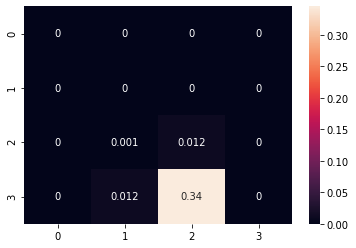

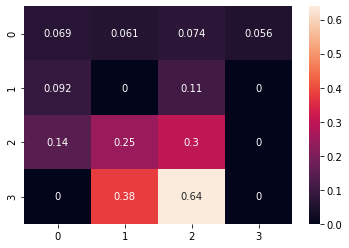

In [377]:
# Experiment 1:
# 4x4 Grid
# Gamma at .1
# Value Iteration and Policy Iteration

gamma = .1

env = gym.make('FrozenLake-v0', map_name="4x4")
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()


Value Iteration Value Array:
[3.81365782e-04 6.33543087e-04 2.78634965e-03 6.96587414e-04
 1.27328582e-03 0.00000000e+00 1.32351609e-02 0.00000000e+00
 5.98506334e-03 2.86520309e-02 7.66246155e-02 0.00000000e+00
 0.00000000e+00 8.93025064e-02 4.17860501e-01 0.00000000e+00]
Value Iteration Output Policy:
[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
Value Iteration - Time per iteration:
0.0003056994506290981
Value Iteration - Total Iterations:
56

Policy Iteration Value Array:
[0.06888452 0.06140916 0.07440581 0.05580298 0.09184873 0.
 0.11220608 0.         0.14543165 0.24749378 0.29961536 0.
 0.         0.37993361 0.63901895 0.        ]
Policy Iteration Output Policy:
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]
Policy Iteration - Time per iteration:
0.013292789459228516
Policy Iteration - Total Iterations:
3

There were 2 differences in the policies

The difference between the value arrays is 1.5386196317890708



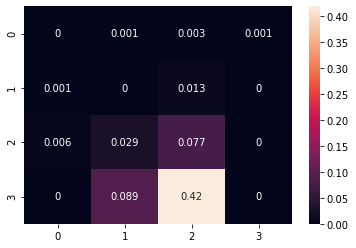

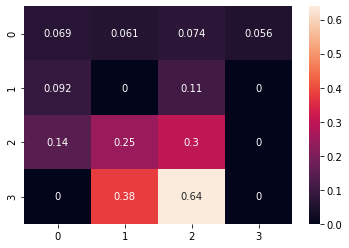

In [312]:
# Experiment 2:
# 4x4 Grid
# Gamma at .5
# Value Iteration and Policy Iteration

gamma = .5

env = gym.make('FrozenLake-v0', map_name="4x4")
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()


Value Iteration Value Array:
[0.0688909  0.06141457 0.07440976 0.05580732 0.09185454 0.
 0.11220821 0.         0.14543635 0.24749695 0.29961759 0.
 0.         0.3799359  0.63902015 0.        ]
Value Iteration Output Policy:
[0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
Value Iteration - Time per iteration:
0.00033217802979892356
Value Iteration - Total Iterations:
266

Policy Iteration Value Array:
[0.06888452 0.06140916 0.07440581 0.05580298 0.09184873 0.
 0.11220608 0.         0.14543165 0.24749378 0.29961536 0.
 0.         0.37993361 0.63901895 0.        ]
Policy Iteration Output Policy:
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]
Policy Iteration - Time per iteration:
0.011899789174397787
Policy Iteration - Total Iterations:
3

The policies are equal

The difference between the value arrays is 4.1615636701276826e-05



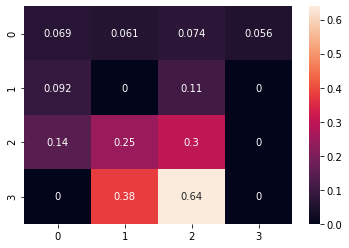

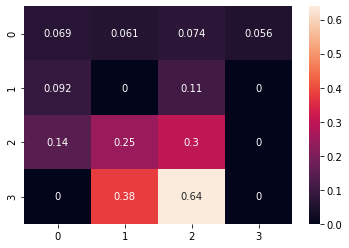

In [313]:
# Experiment 3:
# 4x4 Grid
# Gamma at .9
# Value Iteration and Policy Iteration

gamma = .9

env = gym.make('FrozenLake-v0', map_name="4x4")
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()


Value Iteration Value Array:
[2.90471967e-18 6.09966357e-17 1.29210144e-15 2.69999468e-14
 5.26614876e-13 7.61779498e-12 9.54734125e-11 6.08620831e-10
 2.32402346e-17 4.76800995e-16 1.04709951e-14 2.56383579e-13
 7.65403644e-12 1.25442642e-10 2.16010813e-09 1.70413833e-08
 1.97165808e-16 3.77203815e-15 5.64541710e-14 0.00000000e+00
 1.03651837e-10 1.59551708e-09 4.76364181e-08 4.92040006e-07
 1.94577028e-15 5.62301724e-14 1.67938210e-12 5.02687786e-11
 1.50638398e-09 0.00000000e+00 9.34892427e-07 1.42215238e-05
 1.96441563e-16 3.75103506e-15 5.61044378e-14 0.00000000e+00
 4.50375986e-08 9.04189927e-07 1.37776126e-05 4.11489297e-04
 7.62079783e-18 0.00000000e+00 0.00000000e+00 1.48642558e-08
 4.45431648e-07 1.33030476e-05 0.00000000e+00 1.19189681e-02
 2.45615738e-17 0.00000000e+00 1.65532818e-11 4.96026970e-10
 0.00000000e+00 3.97741806e-04 0.00000000e+00 3.45238585e-01
 7.04664841e-16 1.97306156e-14 5.71483186e-13 0.00000000e+00
 4.10998315e-04 1.19189511e-02 3.45238585e-01 0.00000000

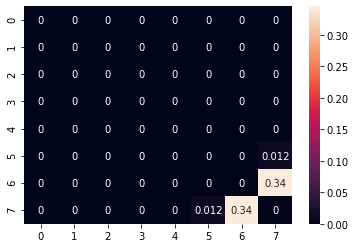

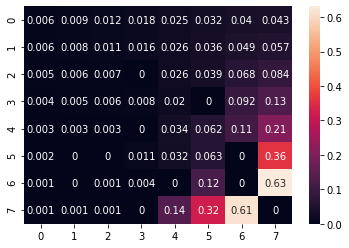

In [314]:
# Experiment 4:
# 8x8 Grid
# Gamma at .1
# Value Iteration and Policy Iteration

gamma = .1

env = gym.make('FrozenLake-v0', map_name="8x8")
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

Value Iteration Value Array:
[2.31052312e-08 8.66989853e-08 3.28061680e-07 1.22041932e-06
 4.26265365e-06 1.19169189e-05 2.93131452e-05 4.76476277e-05
 2.88271708e-08 1.05433247e-07 4.19889076e-07 1.83944296e-06
 9.39634937e-06 3.02714493e-05 9.89180982e-05 1.90590511e-04
 3.87026071e-08 1.26011421e-07 3.51829813e-07 0.00000000e+00
 2.18439933e-05 7.07936786e-05 3.72646629e-04 8.54034455e-04
 6.75016145e-08 2.98805466e-07 1.56507838e-06 8.73983501e-06
 5.08739317e-05 0.00000000e+00 1.28292722e-03 3.89752565e-03
 3.38489212e-08 1.01742992e-07 2.77803562e-07 0.00000000e+00
 2.74659762e-04 1.07671813e-03 3.42739106e-03 1.82047010e-02
 8.26320769e-09 0.00000000e+00 0.00000000e+00 8.92812746e-05
 5.20366504e-04 2.75825799e-03 0.00000000e+00 8.71259794e-02
 7.46711725e-09 0.00000000e+00 2.64558645e-06 1.53211435e-05
 0.00000000e+00 1.49524633e-02 0.00000000e+00 4.17425196e-01
 2.90723786e-08 1.16289514e-07 5.52375193e-07 0.00000000e+00
 1.73913043e-02 8.69565217e-02 4.17391304e-01 0.00000000

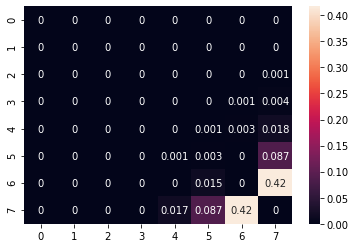

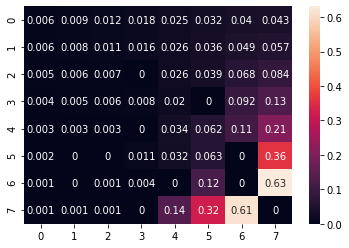

In [315]:
# Experiment 5:
# 8x8 Grid
# Gamma at .5
# Value Iteration and Policy Iteration

gamma = .5

env = gym.make('FrozenLake-v0', map_name="8x8")
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

Value Iteration Value Array:
[0.00641111 0.00854815 0.0123005  0.01778948 0.02508218 0.03247093
 0.03957138 0.04297848 0.00602413 0.00764519 0.01091169 0.0164266
 0.02605416 0.03619413 0.04935474 0.05730465 0.00509032 0.00585328
 0.00677541 0.         0.02557088 0.03882143 0.06763977 0.0843561
 0.00422568 0.00476961 0.00581975 0.00785413 0.02036068 0.
 0.09175505 0.12919114 0.00318101 0.00319666 0.00270492 0.
 0.03444393 0.06195147 0.10901924 0.20969095 0.00186925 0.
 0.         0.0108508  0.03250094 0.06304174 0.         0.36008775
 0.00118058 0.         0.00137719 0.0036684  0.         0.11568672
 0.         0.6305138  0.00088543 0.00077472 0.00092225 0.
 0.13824885 0.32258065 0.61443932 0.        ]
Value Iteration Output Policy:
[3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 1, 3, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0]
Value Iteration - Time per iteration:
0.0011773124621931915
Value

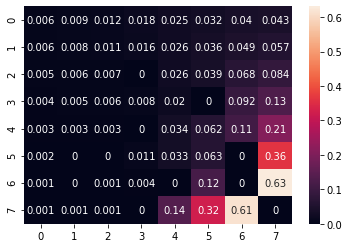

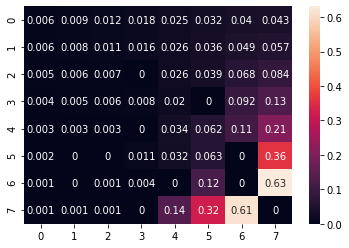

In [316]:
# Experiment 6:
# 8x8 Grid
# Gamma at .9
# Value Iteration and Policy Iteration

gamma = .9

env = gym.make('FrozenLake-v0', map_name="8x8")
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

Value Iteration Value Array:
[2.13040727e-39 4.22915784e-39 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.23934253e-31 4.02943472e-30
 4.40833944e-29 1.27438900e-27 0.00000000e+00 8.52054114e-28
 3.19378392e-27 0.00000000e+00 0.00000000e+00 1.27230007e-30
 5.75526531e-38 1.20515170e-37 3.55367329e-36 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.26465862e-30 7.27702124e-29
 0.00000000e+00 3.69131977e-26 5.52853828e-25 2.15157854e-26
 9.17676795e-26 9.13910380e-27 6.09779629e-28 3.56244020e-29
 1.54851177e-36 0.00000000e+00 1.06489684e-34 3.19113683e-33
 0.00000000e+00 9.23769381e-30 1.74745612e-28 2.17081228e-27
 3.39323589e-26 5.53267714e-25 1.65271859e-23 0.00000000e+00
 2.72237549e-24 1.81795655e-25 9.11866067e-27 4.23328030e-28
 4.48492886e-35 6.39292403e-34 0.00000000e+00 9.56276153e-32
 0.00000000e+00 1.02385202e-28 3.06231838e-27 3.10172639e-26
 4.62532242e-25 0.00000000e+00 4.94709454e-22 2.43648631e-21
 8.13977015e-23 2.72235505e-24 9.11543855e-26 3.15785219

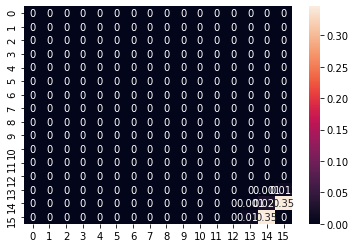

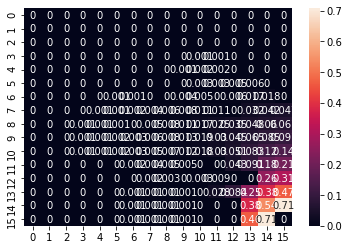

In [317]:
# Experiment 7:
# 16x16 Grid
# Gamma at .1
# Value Iteration and Policy Iteration

gamma = .1

env = gym.make('FrozenLake-v0', desc=map16x16)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

Value Iteration Value Array:
[1.05091024e-17 5.64820079e-18 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.45681379e-14 1.06116787e-13
 2.22570907e-13 1.00673775e-12 0.00000000e+00 7.91918103e-13
 9.04253772e-13 0.00000000e+00 0.00000000e+00 5.47689989e-14
 4.20364096e-17 1.77319015e-17 5.87067989e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.66723903e-13 3.08013029e-13
 0.00000000e+00 4.81111782e-12 1.38107516e-11 3.05533674e-12
 3.72935075e-12 1.74576710e-12 6.07196059e-13 2.19075996e-13
 1.92450146e-16 0.00000000e+00 3.34508892e-16 1.94834655e-15
 0.00000000e+00 1.68830819e-13 6.37762248e-13 1.57523748e-12
 4.48613264e-12 1.40492176e-11 7.49980551e-11 0.00000000e+00
 1.75750007e-11 6.13805577e-12 1.67833326e-12 4.88183919e-13
 9.20214322e-16 2.09139619e-15 0.00000000e+00 1.13555704e-14
 0.00000000e+00 3.75222668e-13 2.08250519e-12 4.32753002e-12
 1.12923408e-11 0.00000000e+00 4.22128361e-10 5.38413018e-10
 9.55825976e-11 1.75075669e-11 3.32474774e-12 7.62586332

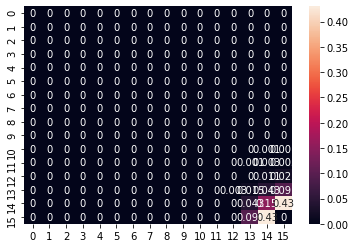

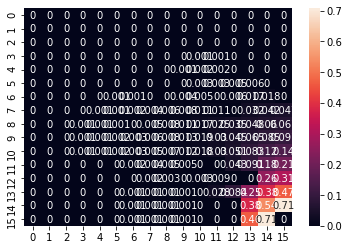

In [318]:
# Experiment 8:
# 16x16 Grid
# Gamma at .5
# Value Iteration and Policy Iteration

gamma = .5

env = gym.make('FrozenLake-v0', desc=map16x16)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

Value Iteration Value Array:
[0.0688909  0.06141457 0.07440976 0.05580732 0.09185454 0.
 0.11220821 0.         0.14543635 0.24749695 0.29961759 0.
 0.         0.3799359  0.63902015 0.        ]
Value Iteration Output Policy:
[0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
Value Iteration - Time per iteration:
0.00029774716025904606
Value Iteration - Total Iterations:
266

Policy Iteration Value Array:
[0.06888452 0.06140916 0.07440581 0.05580298 0.09184873 0.
 0.11220608 0.         0.14543165 0.24749378 0.29961536 0.
 0.         0.37993361 0.63901895 0.        ]
Policy Iteration Output Policy:
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]
Policy Iteration - Time per iteration:
0.014237403869628906
Policy Iteration - Total Iterations:
3

The policies are equal

The difference between the value arrays is 4.1615636701276826e-05



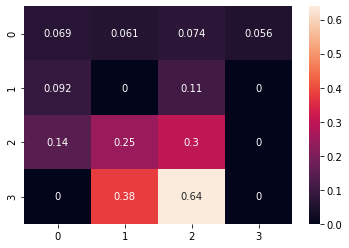

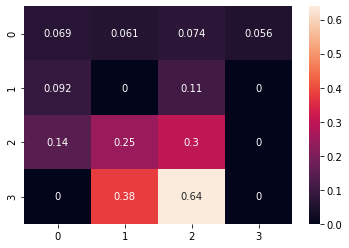

[[5.924656478698689e-34, 6.040000084203572e-34, 1.4137152380371246e-33, 1.4760857636657806e-35], [2.0834012690778085e-34, 1.0626739304508664e-28, 7.559505929316976e-29, 6.044667412214867e-28], [1.331694314303787e-21, 1.7732597919905105e-23, 1.328015722941723e-22, 3.202038564678515e-30], [6.766247477136562e-36, 2.567800736714913e-28, 5.143400617300086e-35, 2.1118468696904097e-28], [1.4549820588872238e-27, 1.931495150729732e-28, 4.053787308896079e-30, 4.92089822035865e-34], [0.0, 0.0, 0.0, 0.0], [5.69995308275557e-23, 8.95839241660631e-21, 2.3471281058794137e-15, 5.563068630781126e-39], [0.0, 0.0, 0.0, 0.0], [5.389077752578528e-34, 1.924535010750343e-21, 3.585181871432972e-26, 7.471720991873784e-27], [2.0879447926422377e-27, 6.702268397697261e-31, 1.2486430627380464e-15, 1.421912242651097e-34], [1.6533944416482622e-10, 1.240671071341097e-15, 8.94863066774562e-10, 3.084497779055295e-22], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [7.80090351959081e-17, 1.628214767604882e-11, 2.7093719285

In [376]:
# Experiment 9:
# 16x16 Grid
# Gamma at .9
# Value Iteration and Policy Iteration

gamma = .9

env = gym.make('FrozenLake-v0', map_name="4x4")
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

#Graphing
sideLen = int(np.sqrt(env.nS))

value = np.round(np.reshape(value, (sideLen, sideLen)), 3)
vfunc = np.round(np.reshape(vfunc, (sideLen, sideLen)), 3)

sns.heatmap(value, annot=True)
plt.show()
sns.heatmap(vfunc, annot=True)
plt.show()

g = gym_qlearning(env, total_episodes=10000, max_steps=500, decay_lr=True)
print(g.tolist())
print(get_qpolicy(g))

In [193]:
# Experiment 10:
# 16x16 Grid
# Gamma at .01
# Value Iteration and Policy Iteration

gamma = .01

env = gym.make('FrozenLake-v0', desc=map16x16)
vi_start = time.time()
value, vi_iters = value_iteration(env, lmbda=gamma)
vi_total = time.time() - vi_start
vi_policy = get_policy(env, value, gamma)
pi_start = time.time()
pi_policy, vfunc, pi_iters = policy_iteration(env, 10000, gamma)
pi_total = time.time() - pi_start

prettify_output(0, np.array(value), vi_policy, vi_iters, vi_total)
prettify_output(1, np.array(vfunc), pi_policy, pi_iters, pi_total)
compare_policies(vi_policy, pi_policy)
compare_values(value, vfunc)

Value Iteration Value Array:
[1.60713093e-68 3.40882809e-67 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.47497013e-54 3.27789232e-52
 3.56651212e-50 1.06635434e-47 0.00000000e+00 7.04368820e-48
 2.56379624e-46 0.00000000e+00 0.00000000e+00 9.57397055e-53
 4.46443866e-66 1.01907889e-64 3.05675612e-62 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.11226837e-52 6.23438593e-50
 0.00000000e+00 3.18836382e-45 4.78247437e-43 1.84968315e-45
 7.66504640e-44 7.66472052e-46 5.10984977e-48 2.85304322e-50
 1.23295927e-63 0.00000000e+00 9.17016646e-60 2.75101937e-57
 0.00000000e+00 7.99003459e-52 1.51020717e-49 1.87021188e-47
 2.93293018e-45 4.78251047e-43 1.43469193e-40 0.00000000e+00
 2.29925230e-41 1.53286042e-43 7.66454348e-46 3.42074947e-48
 3.68650358e-61 5.50212198e-59 0.00000000e+00 8.25296641e-55
 0.00000000e+00 8.86803209e-50 2.66032973e-47 2.67755443e-45
 4.01609305e-43 0.00000000e+00 4.30398014e-38 2.06921211e-36
 6.89752697e-39 2.29925230e-41 7.66451527e-44 2.56349744

In [205]:
# Experiment 11:
# Forest Management
# 1000 States
# Gamma at .1
# QLearning
P, R = ex.forest(S=3000)
ql = QLearning(P, R, .9, n_iter=10000000)
ql.run()
print(ql.Q.tolist())

[[4.481157196690918, 4.027578618685865], [4.473907903398941, 5.032582359117096], [3.6665042184602266, 5.027242437185467], [0.02905529852661201, 4.736147844599124], [0.0003067644114849286, 0.3135921615752278], [0.045814869787535316, 0.011460952750866484], [0.0013592099126312762, 0.5465397867334454], [0.010746855336947187, 0.0018284959117431303], [0.0960973700641583, 0.0038119493264789925], [0.027658153491633957, 0.0022401916166711554], [0.0027779024449531386, 0.3032283245308958], [0.000195643025832305, 0.08899189445175416], [0.0, 0.15254484252794376], [1.276968895356936e-05, 0.04195300064022557], [0.005079006914530466, 0.0040362421256880665], [0.005291854823102417, 0.19340785472869407], [4.465301836511583e-05, 0.038608971339881795], [0.022071761606243006, 0.0064678373988494966], [0.006898343015504437, 0.1293990506368814], [0.021490606300000485, 0.0042838767756548605], [0.0053662889535086985, 0.1289953224992332], [0.011196151063182044, 0.0], [0.025875238859897648, 0.016842453486396253], 

In [206]:
ql.V

(4.481157196690918,
 5.032582359117096,
 5.027242437185467,
 4.736147844599124,
 0.3135921615752278,
 0.045814869787535316,
 0.5465397867334454,
 0.010746855336947187,
 0.0960973700641583,
 0.027658153491633957,
 0.3032283245308958,
 0.08899189445175416,
 0.15254484252794376,
 0.04195300064022557,
 0.005079006914530466,
 0.19340785472869407,
 0.038608971339881795,
 0.022071761606243006,
 0.1293990506368814,
 0.021490606300000485,
 0.1289953224992332,
 0.011196151063182044,
 0.025875238859897648,
 0.3451622795479365,
 0.08598380952969792,
 0.03499112323076155,
 0.11678562606543555,
 0.003745452155446424,
 0.015182425487748586,
 0.25490261327427144,
 0.021359329645058586,
 0.1537867311930985,
 0.14149004462527756,
 0.10838428179357296,
 0.029723726140965544,
 0.1485737722827547,
 0.021021214277469363,
 0.31641102766194534,
 0.010778265094326849,
 0.1514003041768253,
 0.01163372487040339,
 0.04007448828198824,
 0.02894702772892934,
 0.040988550855238046,
 0.04564783254886622,
 0.399563667